# CLUSTERING TEAM ANALYSIS

## 1. Classes

In [1]:
import pyspark
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from functools import reduce

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import configparser
config = configparser.ConfigParser()
config.read('mainconfig_secret.ini')

# Obtener las credenciales
db_host = config['MySQL']['host']
db_user = config['MySQL']['user']
db_password = config['MySQL']['password']
db_name = config['MySQL']['database']
db_table = config['MySQL']['table']
db_port = config['MySQL']['port']

print(pyspark.__file__)

/Users/rodrigobenitogarcia/anaconda3/envs/ml_env/lib/python3.11/site-packages/pyspark/__init__.py


### 1.1. PySpark

In [2]:
class MySpark():
    def __init__(self, my_config_path: str="/Users/rodrigobenitogarcia/jars/mysql-connector-j-9.5.0/mysql-connector-j-9.5.0.jar", my_appName: str="DBConection"):
        """
        Initial configuration for pyspark connection.
        :param my_config_path: path where jar file is located.
        :param my_appName: name of your DB Connection.
        """
        self.config_path = my_config_path
        self.appName = my_appName
        self.mysql_user = db_user
        self.mysql_pwd = db_password
        self.mysql_db = db_name
        self.mysql_table = db_table
        self.mysql_url = f"jdbc:mysql://{db_host}:{db_port}/{self.mysql_db}?serverTimezone=UTC&useSSL=false"
        self.mysql_driver = "com.mysql.cj.jdbc.Driver"
    

    def create_session(self):
        """
        SparkSession constructor
        :return: Get or create a Spark Session
        """
        return SparkSession.builder \
            .appName(self.appName) \
            .config("spark.jars", self.config_path) \
            .config("spark.driver.extraClassPath", self.config_path) \
            .config("spark.executor.extraClassPath", self.config_path) \
            .config("spark.driver.memory", "8g") \
            .config("spark.executor.memory", "8g") \
            .config("spark.driver.maxResultSize", "4g") \
            .config("spark.sql.shuffle.partitions", "200") \
            .getOrCreate()
    
    @staticmethod
    def end_session(my_spark_obj):
        """
        Spark Session end
        :param my_spark_obj: Spark object created
        :return: Close the connection.
        """
        return my_spark_obj.stop()
    
    def load_spark_data(self, my_spark_obj):
        """
        Load the data from Spark object.
        :param my_spark_obj: Spark object created
        :return:
        """
        return my_spark_obj.read.format("jdbc").options(
            url=self.mysql_url,
            driver=self.mysql_driver,
            dbtable=self.mysql_table,
            user=self.mysql_user,
            password=self.mysql_pwd
        ).load()

def rename_columns(df: DataFrame, rename_dict: dict) -> DataFrame:
    """
    Rename multiple columns of a PySpark dataframe using a dictionary.
    Parameters
    ----------
    df : pyspark.sql.DataFrame
        input dataframe.
    rename_dict : dict
        Dict with the key: value.
        Example: {"old_col": "new_col", "old_col2": "new_col2"}
    
    Returns
    -------
    pyspark.sql.DataFrame
        Dataframe with columns renamed.
    """
    return reduce(
        lambda df_temp, kv: df_temp.withColumnRenamed(kv[0], kv[1]),
        rename_dict.items(),
        df
    )

Load the object in order to create the spark session, **remember** to open your sql connection before loading it.

In [3]:
spark_obj = MySpark()
spark_t = spark_obj.create_session()

df = spark_obj.load_spark_data(my_spark_obj=spark_t)

# The following cells will show the basic information related to the dataset previously loaded.
print(f"Número de filas: {df.count()}")
print(f"Número de columnas: {len(df.columns)}")

# Show the Schema
print(df.printSchema())

26/02/17 13:07:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/17 13:07:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Número de filas: 189988
Número de columnas: 13
root
 |-- name: string (nullable = true)
 |-- homeValue: double (nullable = true)
 |-- awayValue: double (nullable = true)
 |-- homeTotal: integer (nullable = true)
 |-- awayTotal: integer (nullable = true)
 |-- period: string (nullable = true)
 |-- LeagueId: integer (nullable = true)
 |-- Year: string (nullable = true)
 |-- SeasonId: integer (nullable = true)
 |-- MatchId: integer (nullable = true)
 |-- Round: string (nullable = true)
 |-- homeTeam: string (nullable = true)
 |-- awayTeam: string (nullable = true)

None


Once the data schema is visualized, we can obtain general statistics like count, mean, stddev, min, max.

In addition, like some of the columns are categorical, we only will show the numeric values.

In [4]:
df.select("homeValue", "awayValue", "homeTotal", "awayTotal").describe().show(truncate=False)

26/02/17 13:07:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-----------------+------------------+------------------+
|summary|homeValue        |awayValue        |homeTotal         |awayTotal         |
+-------+-----------------+-----------------+------------------+------------------+
|count  |189988           |189988           |30475             |30475             |
|mean   |18.18079389224575|17.26238293997513|17.726037735849058|17.510943396226416|
|stddev |48.32237718635825|45.44318214881185|12.546666435798686|12.832449347790691|
|min    |0.0              |0.0              |0                 |0                 |
|max    |513.0            |501.0            |65                |64                |
+-------+-----------------+-----------------+------------------+------------------+



### 1.2. Pandas

### 1.3. General functions

In [5]:
def trim_all_strings(df):
    """
    Trim all the strings collected from the database in order to avoid spaces problems.
    :param df: PySpark dataframe
    :return: PySpark dataframe formatted
    """
    return df.select([
        F.trim(F.col(c)).alias(c) if isinstance(df.schema[c].dataType, StringType) 
        else F.col(c) 
        for c in df.columns
    ])

In [6]:
[row['name'] for row in df.select('name').distinct().collect()]

['Accurate passes                                   ',
 'Duels                                             ',
 'Blocked shots                                     ',
 'Tackles                                           ',
 'Total saves                                       ',
 'Total tackles                                     ',
 'Fouls                                             ',
 'Crosses                                           ',
 'Offsides                                          ',
 'Shots inside box                                  ',
 'Throw-ins                                         ',
 'Dispossessed                                      ',
 'Fouled in final third                             ',
 'Shots on target                                   ',
 'Corner kicks                                      ',
 'Aerial duels                                      ',
 'Passes                                            ',
 'Yellow cards                                      ',
 'Long bal

## 2. Analysis

First of all, let's take a look how the data are saved in the database.
As you can see, we have different columns:
- name: Stats to analyze
- homeValue: Value for the local team
- awayValue: Value for the away team
- homeTotal: Value for the local team if applies (not so useful)
- awayTotal: Value for the away team if applies (not so useful)
- period: 1ST half or 2ND half
- LeagueId: unique Id for each league
- Year: Str season
- SeasonId: unique Id for each season
- Round: Value for the round
- homeTeam: Local Team
- awayTeam: Away Team

In [7]:
df.show(truncate=False)

+--------------------------------------------------+---------+---------+---------+---------+----------+--------+----------+--------+-------+--------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|name                                              |homeValue|awayValue|homeTotal|awayTotal|period    |LeagueId|Year      |SeasonId|MatchId|Round                                             |homeTeam                                                                                            |awayTeam                                                                                            |
+--------------------------------------------------+---------+---------+---------+---------+----------+--------+----------+--------+-------+--------------------------------------------------+---------------------

As you can see in the previous cell, the name of the strings are with spaces, so it is necessary for good practices delete these empty values, that's why the function `trim_all_strings` was created.

In addition, you can check which variables are interested to analyze, on my case I chose the following.

In [8]:
df = trim_all_strings(df=df)
stats_measure = [
    # Attack
    'Shots on target',  'Big chances', 'Final third entries', 'Accurate passes', # 'Expected goals',
    # Defend
    'Tackles won', 'Interceptions', 'Clearances', # 'Recoveries',
    # Control
    'Ball possession', 'Passes', 'Ground duels',
    # Result
    'Goals', 'Goalkeeper saves'
]

print(f"📊 Variables selected: {len(stats_measure)}")
print("\n".join([f"  - {feat}" for feat in stats_measure]))

my_columns = ['name', 'homeValue', 'awayValue', 'period', 'MatchId', 'Year', 'homeTeam', 'awayTeam']
df_filtered_to_cluster = df.filter(F.col('name').isin(stats_measure))
df_filtered_to_cluster = df_filtered_to_cluster.select(*my_columns)

# Ver cuántos datos tenemos
print(f"\n🔢 Total registers: {df_filtered_to_cluster.count()}")
print(f"📅 Seasons: {df_filtered_to_cluster.select('Year').distinct().count()}")

# Verificar que todas las variables están presentes
print("\n✅ Variables availables:")
df_filtered_to_cluster.groupBy('name').count().orderBy('name').show(20, truncate=False)

📊 Variables selected: 12
  - Shots on target
  - Big chances
  - Final third entries
  - Accurate passes
  - Tackles won
  - Interceptions
  - Clearances
  - Ball possession
  - Passes
  - Ground duels
  - Goals
  - Goalkeeper saves

🔢 Total registers: 60820
📅 Seasons: 8

✅ Variables availables:
+-------------------+-----+
|name               |count|
+-------------------+-----+
|Accurate passes    |5084 |
|Ball possession    |5084 |
|Big chances        |4926 |
|Clearances         |5084 |
|Final third entries|5080 |
|Goalkeeper saves   |5058 |
|Goals              |5084 |
|Ground duels       |5084 |
|Interceptions      |5084 |
|Passes             |5084 |
|Shots on target    |5084 |
|Tackles won        |5084 |
+-------------------+-----+



If you analyze the dataset, the number of matches for the season 18/19 are a few, so this could get into trouble in the future for the data analysis, the best choice is delete this season.

In [9]:
df_filtered_to_cluster = df_filtered_to_cluster.filter(F.col('Year') != "18/19")

As many of the values could be string, the best option is to convert values to numerics, avoiding string values.

In [10]:
df_filtered_to_cluster = df_filtered_to_cluster.withColumn('homeValue', F.col('homeValue').cast('double')).withColumn('awayValue', F.col('awayValue').cast('double'))

print("✅ Data filtered and ready to use.")
print(f"📊 Total registers: {df_filtered_to_cluster.count()}")
print(f"📅 Seasons: {sorted([row.Year for row in df_filtered_to_cluster.select('Year').distinct().collect()])}")

# 4. Verificar que todas las variables están presentes
print("\n=== Distribution per variable ===")
df_filtered_to_cluster.groupBy('name').count().orderBy(F.desc('count')).show(15, truncate=False)


✅ Data filtered and ready to use.
📊 Total registers: 60008
📅 Seasons: ['19/20', '20/21', '21/22', '22/23', '23/24', '24/25', '25/26']

=== Distribution per variable ===
+-------------------+-----+
|name               |count|
+-------------------+-----+
|Ball possession    |5016 |
|Tackles won        |5016 |
|Passes             |5016 |
|Shots on target    |5016 |
|Goals              |5016 |
|Interceptions      |5016 |
|Clearances         |5016 |
|Accurate passes    |5016 |
|Ground duels       |5016 |
|Final third entries|5012 |
|Goalkeeper saves   |4990 |
|Big chances        |4862 |
+-------------------+-----+



In [11]:
df_home = df_filtered_to_cluster.select(
    F.col('name').alias('stat'),
    F.col('homeValue').alias('value'),
    F.col('period'),
    F.col('Year').alias('year'),
    F.col('homeTeam').alias('team'),
    F.lit('home').alias('location')
)

df_away = df_filtered_to_cluster.select(
    F.col('name').alias('stat'),
    F.col('awayValue').alias('value'),
    F.col('period'),
    F.col('Year').alias('year'),
    F.col('awayTeam').alias('team'),
    F.lit('away').alias('location')
)

df_combined = df_home.union(df_away)

print(f"✅ Data home: {df_home.count()} registers")
print(f"✅ Data away: {df_away.count()} registers")
print(f"✅ Data combined: {df_combined.count()} registers")

✅ Data home: 60008 registers
✅ Data away: 60008 registers


✅ Data combined: 120016 registers


In [12]:
df_pivot = df_combined.groupBy('team', 'year', 'period', 'location') \
    .pivot('stat') \
    .agg(F.avg('value'))  # avg por si hay duplicados (aunque no debería)

print("\n✅ Pivot data")
df_pivot.printSchema()
df_pivot.show(5, truncate=False)


✅ Pivot data
root
 |-- team: string (nullable = true)
 |-- year: string (nullable = true)
 |-- period: string (nullable = true)
 |-- location: string (nullable = false)
 |-- Accurate passes: double (nullable = true)
 |-- Ball possession: double (nullable = true)
 |-- Big chances: double (nullable = true)
 |-- Clearances: double (nullable = true)
 |-- Final third entries: double (nullable = true)
 |-- Goalkeeper saves: double (nullable = true)
 |-- Goals: double (nullable = true)
 |-- Ground duels: double (nullable = true)
 |-- Interceptions: double (nullable = true)
 |-- Passes: double (nullable = true)
 |-- Shots on target: double (nullable = true)
 |-- Tackles won: double (nullable = true)



+----------------+-----+------+--------+------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|team            |year |period|location|Accurate passes   |Ball possession  |Big chances       |Clearances        |Final third entries|Goalkeeper saves  |Goals              |Ground duels      |Interceptions     |Passes            |Shots on target   |Tackles won       |
+----------------+-----+------+--------+------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|osasuna         |20/21|2ND   |home    |134.31578947368422|46.21052631578947|0.7777777777777778|8.578947368421053 |31.68421052631579  |1.0526315789473684|0.631578947368421  |15.3157894736842

In [13]:
df_aggregated_multi = df_pivot.groupBy('team', 'year', 'location').agg(
    F.avg('Ball possession').alias('ball_possession'),
    F.sum('Shots on target').alias('shots_on_target'),
    F.sum('Big chances').alias('big_chances'),
    F.sum('Final third entries').alias('final_third_entries'),
    F.sum('Accurate passes').alias('accurate_passes'),
    F.sum('Goals').alias('goals'),
    F.sum('Tackles won').alias('tackles_won'),
    F.sum('Interceptions').alias('interceptions'),
    F.sum('Clearances').alias('clearances'),
    F.sum('Goalkeeper saves').alias('goalkeeper_saves'),
    F.sum('Passes').alias('passes'),
    F.sum('Ground duels').alias('ground_duels')
)

print(f"📊 Registers: {df_aggregated_multi.count()} (2 per team-season: home and away)")

📊 Registers: 280 (2 per team-season: home and away)


Once the data have been transformed and structured like we need, we are going to convert to Pandas for an easy handle.

In [14]:
# Convert to pandas
df_pandas_multi = df_aggregated_multi.toPandas()

print(f"\n✅ Convert to Pandas: {len(df_pandas_multi)} registers")
print(f"📊 Columns: {df_pandas_multi.columns.tolist()}")

# Verify null values
print("\n🔍 Verify null values:")
print(df_pandas_multi.isnull().sum())


✅ Convert to Pandas: 280 registers
📊 Columns: ['team', 'year', 'location', 'ball_possession', 'shots_on_target', 'big_chances', 'final_third_entries', 'accurate_passes', 'goals', 'tackles_won', 'interceptions', 'clearances', 'goalkeeper_saves', 'passes', 'ground_duels']

🔍 Verify null values:
team                   0
year                   0
location               0
ball_possession        0
shots_on_target        0
big_chances            0
final_third_entries    0
accurate_passes        0
goals                  0
tackles_won            0
interceptions          0
clearances             0
goalkeeper_saves       0
passes                 0
ground_duels           0
dtype: int64


### 2.1. Correlation between variables

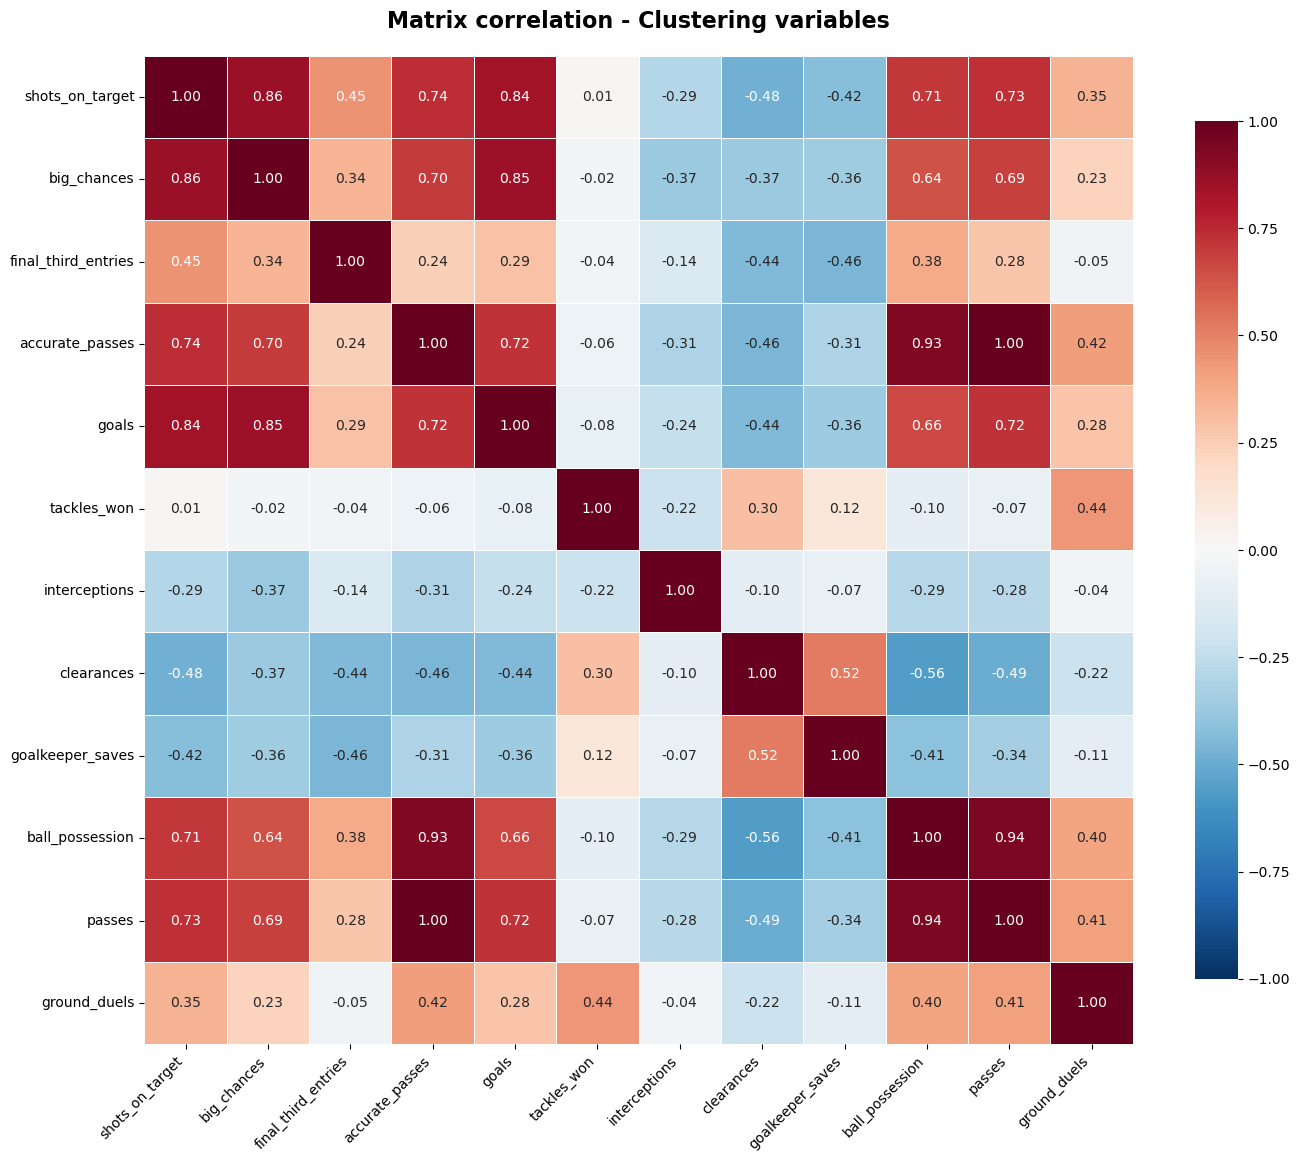


=== HIGH CORRELATION (|r| > 0.80) ===
  shots_on_target <-> big_chances: 0.862
  shots_on_target <-> goals: 0.844
  big_chances <-> goals: 0.853
  accurate_passes <-> ball_possession: 0.930
  accurate_passes <-> passes: 0.996
  ball_possession <-> passes: 0.943


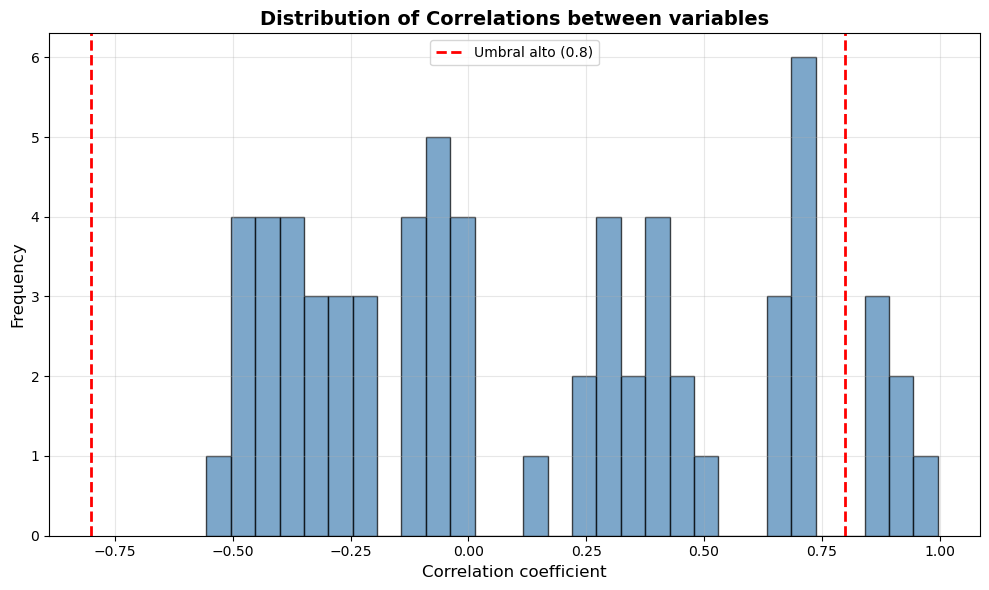


=== CORRELATION SUM UP ===
Mean correlation: 0.124
Max Correlation: 0.996
Min Correlation: -0.556
Estandar Deviation: 0.453


In [28]:
# Select only numeric columns (features)
feature_columns = [
    # Attack (5)
    'shots_on_target',      # Amount of opportunities
    'big_chances',          # Quality of opportunities
    'final_third_entries',  # High pressure
    'accurate_passes',      # Passes accuracy
    'goals',                # Conversion goals
    
    # Defence (4)
    'tackles_won',          # Pressure
    'interceptions',        # Interceptions
    'clearances',           # Solidity
    'goalkeeper_saves',     # Goalkeeper activity
    
    # Control (2)
    'ball_possession',      # Domain
    'passes',
    
    # Intensity (1)
    'ground_duels'          # Physical 
]

# Matrix correlation
correlation_matrix = df_pandas_multi[feature_columns].corr()

# print("=== MATRIX CORRELATION ===")
# print(correlation_matrix.round(2))

# Visual 1: Heatmap correlation
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, 
            annot=True,          # Values
            fmt='.2f',           # 2 decimals
            cmap='RdBu_r',       # Colours: red (negative) a blue (positive)
            center=0,            # Align to 0
            square=True,         # Square cells
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)

plt.title('Matrix correlation - Clustering variables', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n=== HIGH CORRELATION (|r| > 0.80) ===")
high_corr = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.80:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            high_corr.append((var1, var2, corr_value))
            print(f"  {var1} <-> {var2}: {corr_value:.3f}")

if len(high_corr) == 0:
    print("  ✅ There is not extremaly high correlation")

# Visual 2: Distribution of correlations
plt.figure(figsize=(10, 6))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
corr_values = correlation_matrix.mask(mask).values.flatten()
corr_values = corr_values[~np.isnan(corr_values)]

plt.hist(corr_values, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(x=0.8, color='red', linestyle='--', linewidth=2, label='Umbral alto (0.8)')
plt.axvline(x=-0.8, color='red', linestyle='--', linewidth=2)
plt.xlabel('Correlation coefficient', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Correlations between variables', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Resumen estadístico
print("\n=== CORRELATION SUM UP ===")
print(f"Mean correlation: {corr_values.mean():.3f}")
print(f"Max Correlation: {corr_values.max():.3f}")
print(f"Min Correlation: {corr_values.min():.3f}")
print(f"Estandar Deviation: {corr_values.std():.3f}")

✅ Final vars: 11
  - shots_on_target
  - big_chances
  - final_third_entries
  - accurate_passes
  - goals
  - tackles_won
  - interceptions
  - clearances
  - goalkeeper_saves
  - ball_possession
  - ground_duels

📊 Final dataset: 280 registers x 11 features

=== NEW CORRELATION MATRIX (without redundant data) ===
  shots_on_target <-> big_chances: 0.862
  big_chances <-> goals: 0.853
  accurate_passes <-> ball_possession: 0.930

✅ Correlations |r| > 0.85: 3


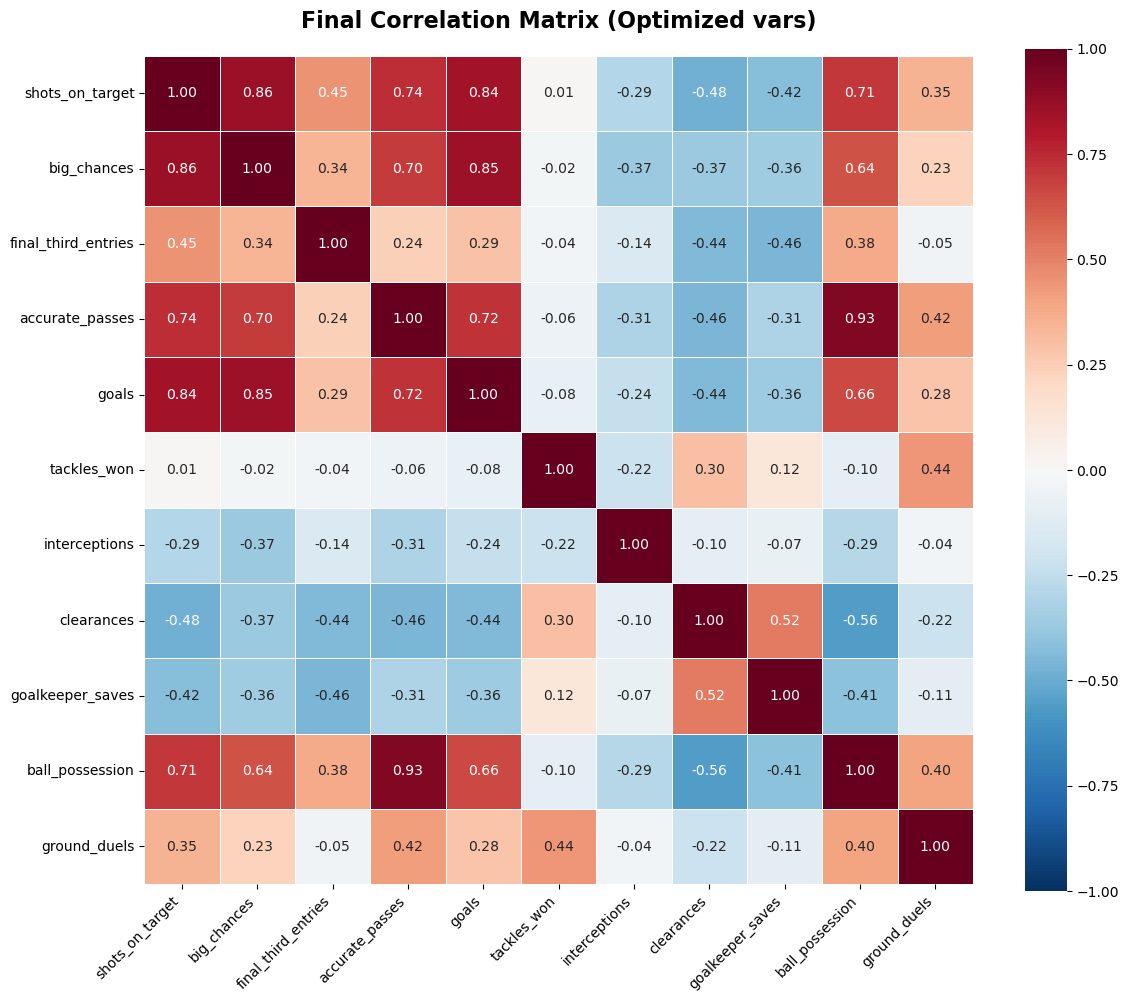


=== DESCRIPTIVE STATISTICS ===
       shots_on_target  big_chances  final_third_entries  accurate_passes  \
count           280.00       280.00               280.00           280.00   
mean              4.07         2.08                54.38           349.74   
std               1.13         0.74                 6.86            95.97   
min               2.26         0.74                39.95           169.37   
25%               3.32         1.57                49.76           276.63   
50%               3.84         1.89                53.50           340.18   
75%               4.59         2.48                58.29           395.34   
max               7.82         4.83                77.47           652.79   

        goals  tackles_won  interceptions  clearances  goalkeeper_saves  \
count  280.00       280.00         280.00      280.00            280.00   
mean     1.28         9.40           8.75       19.35              2.81   
std      0.48         1.21           1.43        

In [16]:
# Redundant vars to remove
variables_a_eliminar = ['passes']  # Redundant with accurate_passes

# Final vars for clustering
final_features = [
    # Attack (5)
    'shots_on_target',      # Amount of opportunities
    'big_chances',          # Quality of opportunities
    'final_third_entries',  # High pressure
    'accurate_passes',      # Passes accuracy
    'goals',                # Conversion goals
    
    # Defence (4)
    'tackles_won',          # Pressure
    'interceptions',        # Interceptions
    'clearances',           # Solidity
    'goalkeeper_saves',     # Goalkeeper activity
    
    # Control (1)
    'ball_possession',      # Domain
    
    # Intensity (1)
    'ground_duels'          # Physical 
]

print(f"✅ Final vars: {len(final_features)}")
print("\n".join([f"  - {feat}" for feat in final_features]))

df_final_features = df_pandas_multi[['team', 'year', 'location'] + final_features].copy()

print(f"\n📊 Final dataset: {len(df_final_features)} registers x {len(final_features)} features")

print("\n=== NEW CORRELATION MATRIX (without redundant data) ===")
correlation_matrix_final = df_final_features[final_features].corr()

high_corr_count = 0
for i in range(len(correlation_matrix_final.columns)):
    for j in range(i+1, len(correlation_matrix_final.columns)):
        if abs(correlation_matrix_final.iloc[i, j]) > 0.85:
            high_corr_count += 1
            print(f"  {correlation_matrix_final.columns[i]} <-> {correlation_matrix_final.columns[j]}: {correlation_matrix_final.iloc[i, j]:.3f}")

print(f"\n✅ Correlations |r| > 0.85: {high_corr_count}")

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_final, 
            annot=True,
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            vmin=-1, vmax=1)
plt.title('Final Correlation Matrix (Optimized vars)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n=== DESCRIPTIVE STATISTICS ===")
print(df_final_features[final_features].describe().round(2))

=== BEFORE STANDARIZATION ===
       shots_on_target  big_chances  final_third_entries  accurate_passes  \
count           280.00       280.00               280.00           280.00   
mean              4.07         2.08                54.38           349.74   
std               1.13         0.74                 6.86            95.97   
min               2.26         0.74                39.95           169.37   
25%               3.32         1.57                49.76           276.63   
50%               3.84         1.89                53.50           340.18   
75%               4.59         2.48                58.29           395.34   
max               7.82         4.83                77.47           652.79   

        goals  tackles_won  interceptions  clearances  goalkeeper_saves  \
count  280.00       280.00         280.00      280.00            280.00   
mean     1.28         9.40           8.75       19.35              2.81   
std      0.48         1.21           1.43        4.

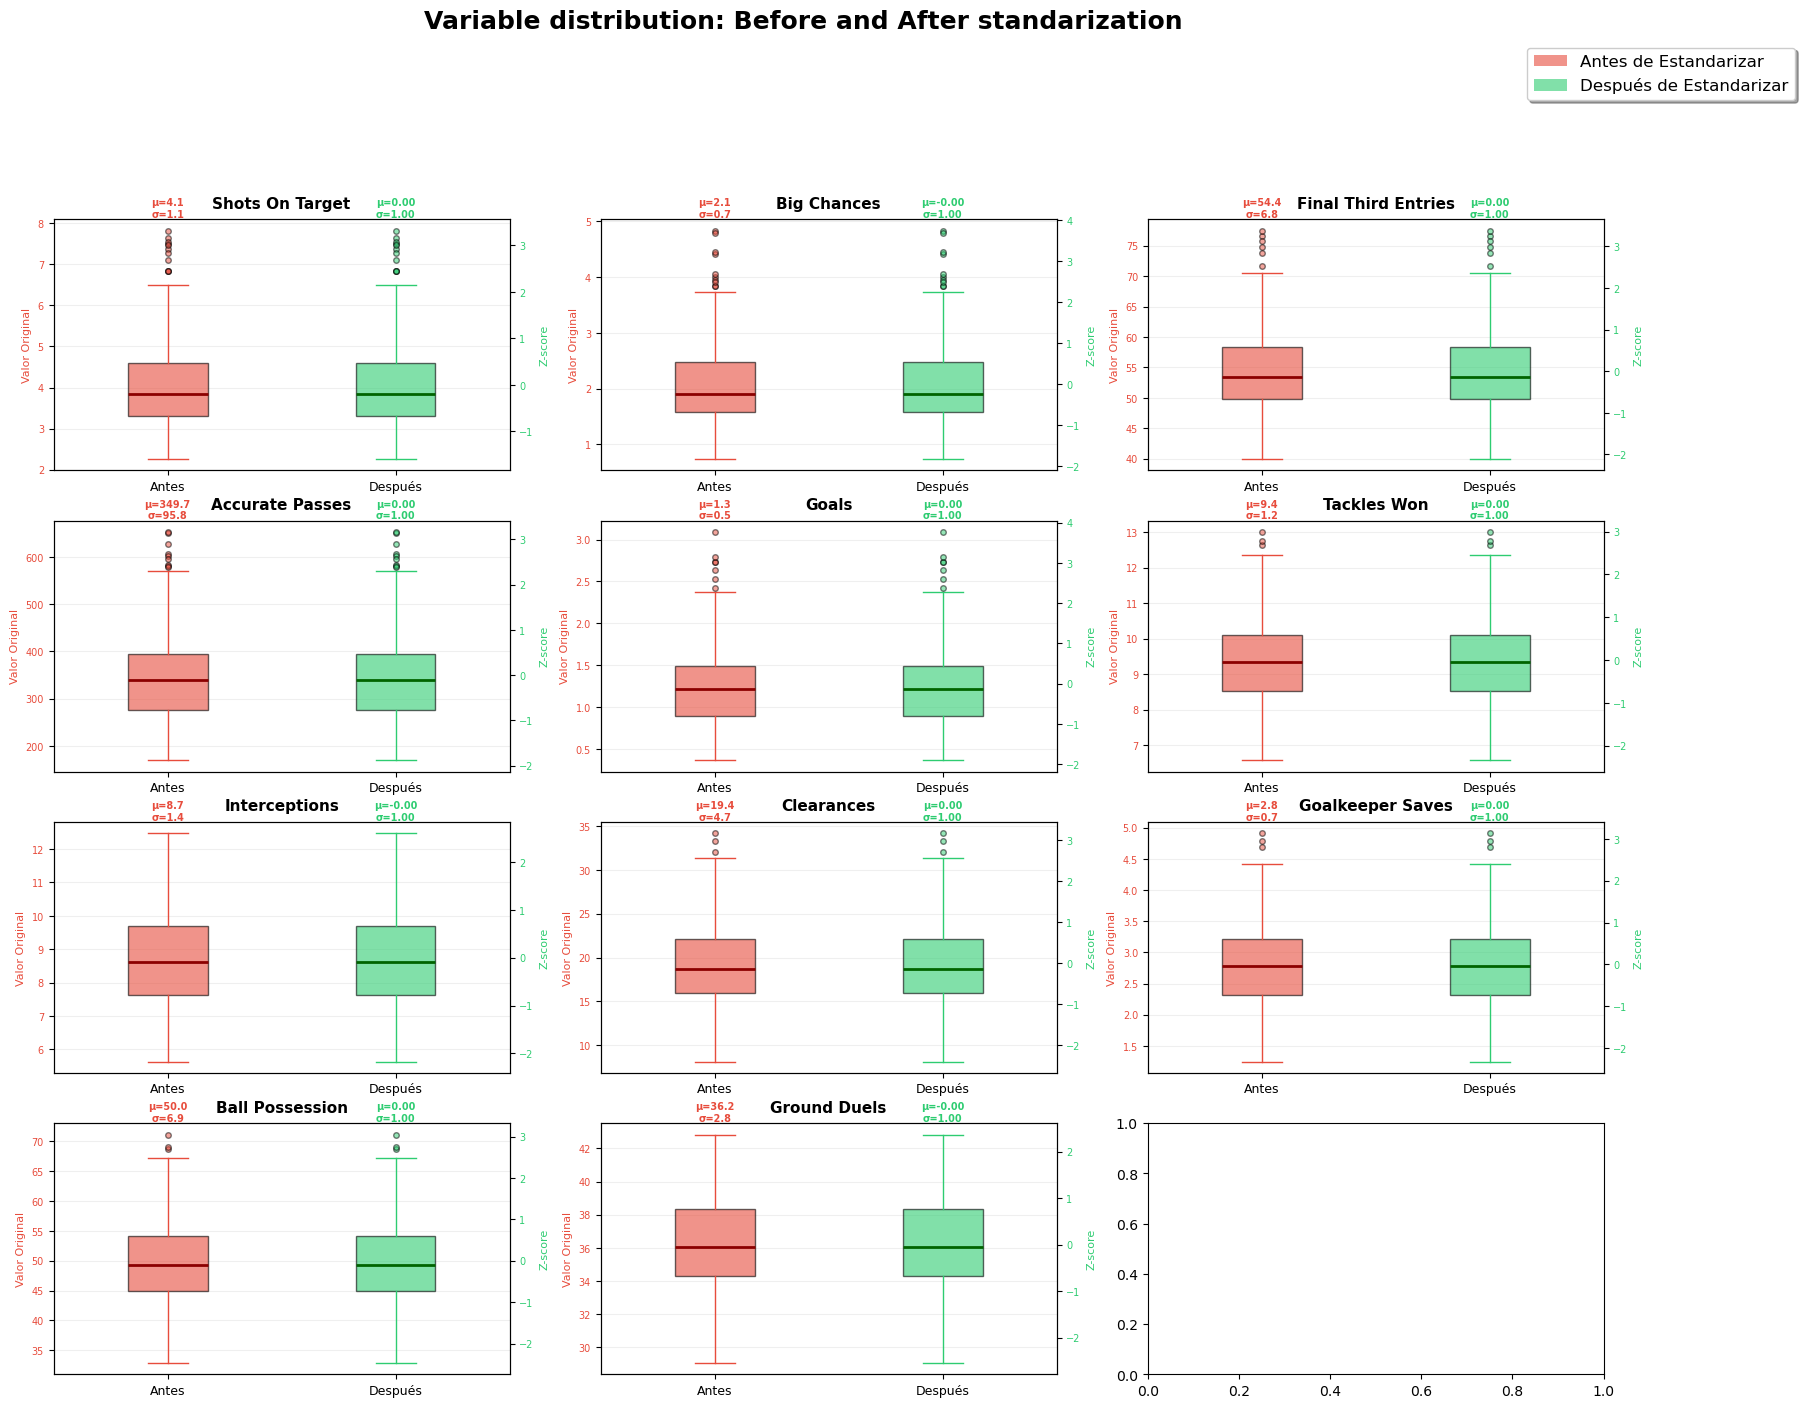

In [32]:
# Step 1: data preparation
print("=== BEFORE STANDARIZATION ===")
print(df_final_features[final_features].describe().round(2))

# Step 2: Create Scaler
scaler = StandardScaler()

# Step 3: Apply standarization only to numeric features
X_scaled = scaler.fit_transform(df_final_features[final_features])

df_scaled = pd.DataFrame(
    X_scaled, 
    columns=final_features,
    index=df_final_features.index
)

# Add categorical features
df_scaled['team'] = df_final_features['team'].values
df_scaled['year'] = df_final_features['year'].values
df_scaled['location'] = df_final_features['location'].values

print("\n=== AFTER STANDARIZATION ===")
print(df_scaled[final_features].describe().round(2))

print("\n✅ STANDARIZATION VERIFIED:")
print(f"Mean of the features: {df_scaled[final_features].mean().mean():.6f} (should be ~0)")
print(f"Desv. Std of the features: {df_scaled[final_features].std().mean():.6f} (should be ~1)")

# Visual: Comparation between before and after
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
fig.suptitle('Variable distribution: Before and After standarization', 
             fontsize=18, fontweight='bold', y=1.02)

color_before = '#E74C3C'  # Red - before
color_after = '#2ECC71'   # Green - after

for idx, feature in enumerate(final_features):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Datos
    data_before = df_final_features[feature].dropna().values
    data_after = df_scaled[feature].dropna().values
    
    # Crear dos ejes Y (uno para cada escala)
    ax2 = ax.twinx()
    
    # Boxplot ANTES en eje izquierdo
    bp1 = ax.boxplot(data_before, positions=[1], widths=0.35,
                     patch_artist=True,
                     boxprops=dict(facecolor=color_before, alpha=0.6),
                     medianprops=dict(color='darkred', linewidth=2),
                     whiskerprops=dict(color=color_before),
                     capprops=dict(color=color_before),
                     flierprops=dict(marker='o', markerfacecolor=color_before, 
                                    markersize=4, alpha=0.5))
    
    # Boxplot DESPUÉS en eje derecho
    bp2 = ax2.boxplot(data_after, positions=[2], widths=0.35,
                      patch_artist=True,
                      boxprops=dict(facecolor=color_after, alpha=0.6),
                      medianprops=dict(color='darkgreen', linewidth=2),
                      whiskerprops=dict(color=color_after),
                      capprops=dict(color=color_after),
                      flierprops=dict(marker='o', markerfacecolor=color_after, 
                                     markersize=4, alpha=0.5))
    
    # Formato ejes
    ax.set_ylabel('Valor Original', fontsize=8, color=color_before)
    ax2.set_ylabel('Z-score', fontsize=8, color=color_after)
    ax.tick_params(axis='y', labelcolor=color_before, labelsize=7)
    ax2.tick_params(axis='y', labelcolor=color_after, labelsize=7)
    
    # Título
    ax.set_title(feature.replace('_', ' ').title(), 
                 fontsize=11, fontweight='bold', pad=8)
    
    # Eje X
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Antes', 'Después'], fontsize=9)
    ax.set_xlim(0.5, 2.5)
    ax.grid(True, alpha=0.2, axis='y')
    
    # Estadísticas
    stats_before = f'μ={data_before.mean():.1f}\nσ={data_before.std():.1f}'
    stats_after = f'μ={data_after.mean():.2f}\nσ={data_after.std():.2f}'
    
    ax.text(1, ax.get_ylim()[1], stats_before, 
            ha='center', va='bottom', fontsize=7, color=color_before,
            fontweight='bold')
    ax2.text(2, ax2.get_ylim()[1], stats_after, 
             ha='center', va='bottom', fontsize=7, color=color_after,
             fontweight='bold')

# Leyenda global
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color_before, alpha=0.6, label='Antes de Estandarizar'),
    Patch(facecolor=color_after, alpha=0.6, label='Después de Estandarizar')
]
fig.legend(handles=legend_elements, loc='upper right', 
           fontsize=12, bbox_to_anchor=(1.0, 1.0),
           frameon=True, fancybox=True, shadow=True)

# # Before standarizaction
# ax1 = axes[0]
# df_final_features[final_features].boxplot(ax=ax1, rot=90)
# ax1.set_title('ANTES de Estandarizar', fontsize=14, fontweight='bold')
# ax1.set_ylabel('Valor Original', fontsize=12)
# ax1.grid(True, alpha=0.3)
# ax1.tick_params(axis='x', labelsize=9)
# 
# # After standarizaction
# ax2 = axes[1]
# df_scaled[final_features].boxplot(ax=ax2, rot=90)
# ax2.set_title('DESPUÉS de Estandarizar (Media=0, Std=1)', fontsize=14, fontweight='bold')
# ax2.set_ylabel('Valor Estandarizado (Z-score)', fontsize=12)
# ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
# ax2.grid(True, alpha=0.3)
# ax2.tick_params(axis='x', labelsize=9)
# 
# plt.tight_layout()
# plt.show()

print("\n=== TRANSFORMATION EXAMPLE ===")
print("\nReal Madrid 19/20 - home (ORIGINAL):")
example_orig = df_final_features[(df_final_features['team'] == 'real-madrid') & 
                                 (df_final_features['year'] == '19/20') & 
                                 (df_final_features['location'] == 'home')]
if len(example_orig) > 0:
    print(example_orig[final_features].iloc[0])
    
    print("\nReal Madrid 19/20 - home (STANDARIZED):")
    example_scaled = df_scaled[(df_scaled['team'] == 'real-madrid') & 
                               (df_scaled['year'] == '19/20') & 
                               (df_scaled['location'] == 'home')]
    print(example_scaled[final_features].iloc[0])

print("\n=== SCALER PARAMETERS ===")
scaling_params = pd.DataFrame({
    'feature': final_features,
    'media_original': scaler.mean_,
    'std_original': scaler.scale_
}).round(2)
print(scaling_params)

print("\n✅ Finish standarization")
print(f"📊 Dataset standarized: {len(df_scaled)} registers x {len(final_features)} features")

### 2.2. PCA

=== VARIANCE EXPLAINED PER COMPONENT ===
PC1: 46.20% (Aggregate: 46.20%)
PC2: 15.53% (Aggregate: 61.73%)
PC3: 10.63% (Aggregate: 72.36%)
PC4: 9.08% (Aggregate: 81.43%)
PC5: 5.87% (Aggregate: 87.30%)
PC6: 4.34% (Aggregate: 91.64%)
PC7: 3.39% (Aggregate: 95.03%)
PC8: 2.29% (Aggregate: 97.32%)
PC9: 1.24% (Aggregate: 98.56%)
PC10: 1.02% (Aggregate: 99.58%)
PC11: 0.42% (Aggregate: 100.00%)


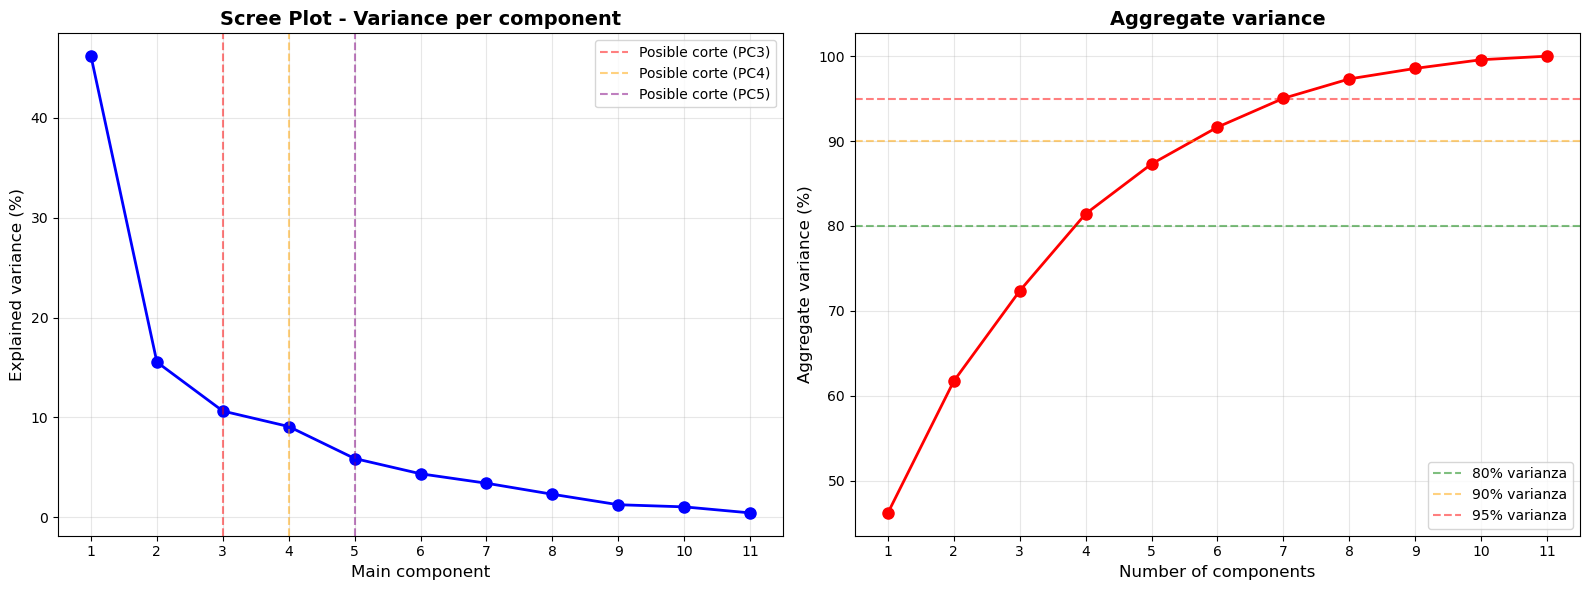


=== COMPONENTS NEEDED ===
To explain 80% of variance: 4 components (81.43%)
To explain 90% of variance: 6 components (91.64%)
To explain 95% of variance: 7 components (95.03%)

=== LOADINGS FIRST 4 COMPONENTS ===
                       PC1    PC2    PC3    PC4
shots_on_target      0.405  0.064 -0.069  0.028
big_chances          0.381  0.098 -0.233 -0.039
final_third_entries  0.223 -0.270 -0.064  0.669
accurate_passes      0.387  0.122 -0.009 -0.272
goals                0.384  0.050 -0.121 -0.171
tackles_won         -0.027  0.575  0.305  0.476
interceptions       -0.139 -0.387  0.552 -0.263
clearances          -0.283  0.374 -0.277  0.030
goalkeeper_saves    -0.242  0.343 -0.253 -0.347
ball_possession      0.391  0.025  0.043 -0.145
ground_duels         0.178  0.397  0.618 -0.099


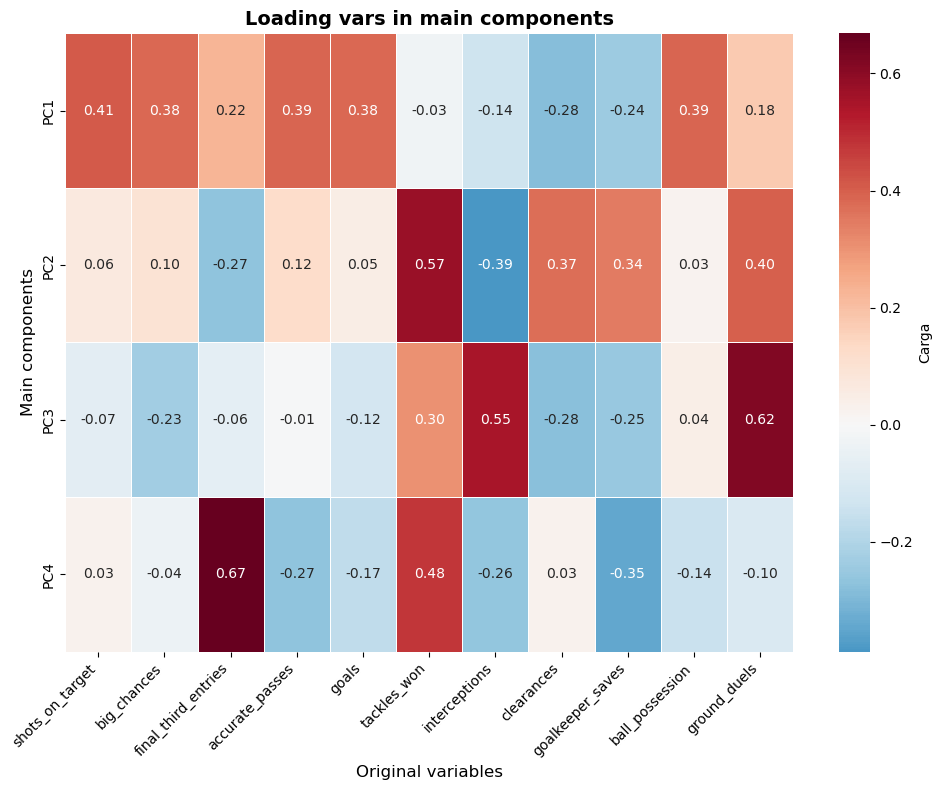


=== INTERPRETATION OF MAIN COMPONENTES ===

🎯 PC1 (Variance: 46.20%):
  POSITIVE Contributions (↑):
    • shots_on_target: 0.405
    • ball_possession: 0.391
    • accurate_passes: 0.387
  NEGATIVE Contributions (↓):
    • clearances: -0.283
    • goalkeeper_saves: -0.242
    • interceptions: -0.139

🎯 PC2 (Variance: 15.53%):
  POSITIVE Contributions (↑):
    • tackles_won: 0.575
    • ground_duels: 0.397
    • clearances: 0.374
  NEGATIVE Contributions (↓):
    • interceptions: -0.387
    • final_third_entries: -0.270
    • ball_possession: 0.025

🎯 PC3 (Variance: 10.63%):
  POSITIVE Contributions (↑):
    • ground_duels: 0.618
    • interceptions: 0.552
    • tackles_won: 0.305
  NEGATIVE Contributions (↓):
    • clearances: -0.277
    • goalkeeper_saves: -0.253
    • big_chances: -0.233

🎯 PC4 (Variance: 9.08%):
  POSITIVE Contributions (↑):
    • final_third_entries: 0.669
    • tackles_won: 0.476
    • clearances: 0.030
  NEGATIVE Contributions (↓):
    • goalkeeper_saves: -0.347

In [18]:
# Step 1: Apply PCA to all the components (11)
pca_full = PCA(n_components=11)
X_pca_full = pca_full.fit_transform(df_scaled[final_features])

# Variance per component
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("=== VARIANCE EXPLAINED PER COMPONENT ===")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance), 1):
    print(f"PC{i}: {var*100:.2f}% (Aggregate: {cum_var*100:.2f}%)")

# Visual 1: Scree Plot (Elbow-Method for PCA)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Individual variance
ax1 = axes[0]
components = range(1, len(explained_variance) + 1)
ax1.plot(components, explained_variance * 100, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Main component', fontsize=12)
ax1.set_ylabel('Explained variance (%)', fontsize=12)
ax1.set_title('Scree Plot - Variance per component', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(components)

# Get the "elbow"
ax1.axvline(x=3, color='red', linestyle='--', alpha=0.5, label='Posible corte (PC3)')
ax1.axvline(x=4, color='orange', linestyle='--', alpha=0.5, label='Posible corte (PC4)')
ax1.axvline(x=5, color='purple', linestyle='--', alpha=0.5, label='Posible corte (PC5)')
ax1.legend()

# Chart 2: Aggregate variance
ax2 = axes[1]
ax2.plot(components, cumulative_variance * 100, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of components', fontsize=12)
ax2.set_ylabel('Aggregate variance (%)', fontsize=12)
ax2.set_title('Aggregate variance', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(components)

# Reference lines
ax2.axhline(y=80, color='green', linestyle='--', alpha=0.5, label='80% varianza')
ax2.axhline(y=90, color='orange', linestyle='--', alpha=0.5, label='90% varianza')
ax2.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='95% varianza')
ax2.legend()

plt.tight_layout()
plt.show()

# Number of component to 80%, 90%, 95%
n_comp_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_comp_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_comp_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\n=== COMPONENTS NEEDED ===")
print(f"To explain 80% of variance: {n_comp_80} components ({cumulative_variance[n_comp_80-1]*100:.2f}%)")
print(f"To explain 90% of variance: {n_comp_90} components ({cumulative_variance[n_comp_90-1]*100:.2f}%)")
print(f"To explain 95% of variance: {n_comp_95} components ({cumulative_variance[n_comp_95-1]*100:.2f}%)")

# Step 2: Interpreting the main components
n_show = 4  # Show first 4 components

loadings = pd.DataFrame(
    pca_full.components_[:n_show, :].T,
    columns=[f'PC{i+1}' for i in range(n_show)],
    index=final_features
)

print(f"\n=== LOADINGS FIRST {n_show} COMPONENTS ===")
print(loadings.round(3))

# Visual 2: Loadings Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(loadings.T, 
            annot=True, 
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            cbar_kws={'label': 'Carga'},
            linewidths=0.5)
plt.title('Loading vars in main components', fontsize=14, fontweight='bold')
plt.xlabel('Original variables', fontsize=12)
plt.ylabel('Main components', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Identify each component
print("\n=== INTERPRETATION OF MAIN COMPONENTES ===")
for i in range(n_show):
    print(f"\n🎯 PC{i+1} (Variance: {explained_variance[i]*100:.2f}%):")
    
    # Top 3 contribuciones positivas
    top_positive = loadings[f'PC{i+1}'].nlargest(3)
    print("  POSITIVE Contributions (↑):")
    for var, val in top_positive.items():
        print(f"    • {var}: {val:.3f}")
    
    # Top 3 contribuciones negativas
    top_negative = loadings[f'PC{i+1}'].nsmallest(3)
    print("  NEGATIVE Contributions (↓):")
    for var, val in top_negative.items():
        print(f"    • {var}: {val:.3f}")

print("\n" + "="*80)
print("🎯 Recommendation: how many components to use?")
print("="*80)
print(f"Conservative option: {n_comp_80} components (80% variance)")
print(f"Balance option: {n_comp_90} components (90% variance)")
print(f"Full option: {n_comp_95} components (95% variance)")

✅ PCA apply to 4 components
📊 Variance explained: 81.43%

=== FINAL LOADINGS (4 COMPONENTS) ===
                       PC1    PC2    PC3    PC4
shots_on_target      0.405  0.064 -0.069  0.028
big_chances          0.381  0.098 -0.233 -0.039
final_third_entries  0.223 -0.270 -0.064  0.669
accurate_passes      0.387  0.122 -0.009 -0.272
goals                0.384  0.050 -0.121 -0.171
tackles_won         -0.027  0.575  0.305  0.476
interceptions       -0.139 -0.387  0.552 -0.263
clearances          -0.283  0.374 -0.277  0.030
goalkeeper_saves    -0.242  0.343 -0.253 -0.347
ball_possession      0.391  0.025  0.043 -0.145
ground_duels         0.178  0.397  0.618 -0.099

=== INTERPRETATION OF 4 MAIN COMPONENTS ===

PC1 - Variance explained: 46.20%
🔵 STRONG POSITIVE LOADS:
   • shots_on_target: 0.405
   • ball_possession: 0.391
   • accurate_passes: 0.387
🔴 STRONG NEGATIVE LOADS:
   • clearances: -0.283
   • goalkeeper_saves: -0.242
   • interceptions: -0.139

PC2 - Variance explained: 15.53%


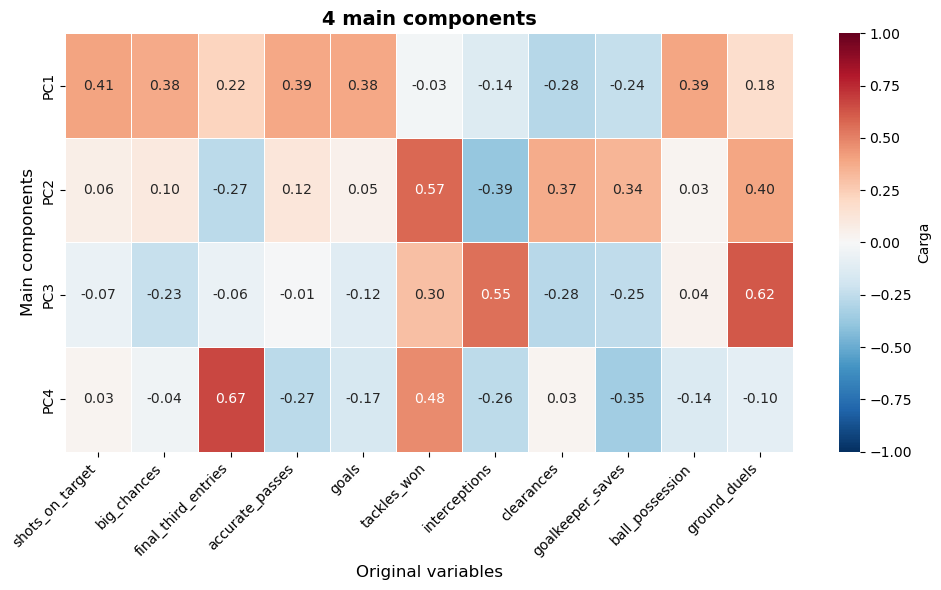


=== PCA ===
        PC1       PC2       PC3       PC4             team   year location
0 -2.223103 -0.077121 -0.760379 -0.373088          granada  21/22     away
1 -0.525042  1.643460  0.465881 -0.558401       real-betis  24/25     away
2 -1.532336 -1.586769  0.003441 -1.552429         valencia  20/21     away
3 -2.955813  0.689927 -0.873354  0.584342            cadiz  23/24     away
4  1.050345  0.893863 -0.252134 -0.174690          almeria  23/24     home
5 -2.231077 -2.256191 -0.536356 -0.741816          granada  20/21     away
6 -0.222206  0.810226 -0.394600 -1.545299        girona-fc  22/23     away
7  0.330764  1.137619  0.221138  0.772897         valencia  24/25     home
8 -2.060377  0.872160 -0.019923 -0.032686   rayo-vallecano  23/24     away
9 -2.677290  2.794082  1.750234 -0.419342  real-valladolid  22/23     away


In [19]:
n_components_final = 4

pca_final = PCA(n_components=n_components_final)
X_pca = pca_final.fit_transform(df_scaled[final_features])

df_pca = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(n_components_final)]
)

df_pca['team'] = df_scaled['team'].values
df_pca['year'] = df_scaled['year'].values
df_pca['location'] = df_scaled['location'].values

print(f"✅ PCA apply to {n_components_final} components")
print(f"📊 Variance explained: {pca_final.explained_variance_ratio_.sum()*100:.2f}%")

loadings_final = pd.DataFrame(
    pca_final.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_final)],
    index=final_features
)

print("\n=== FINAL LOADINGS (4 COMPONENTS) ===")
print(loadings_final.round(3))

print("\n=== INTERPRETATION OF 4 MAIN COMPONENTS ===")
for i in range(n_components_final):
    print(f"\n{'='*80}")
    print(f"PC{i+1} - Variance explained: {pca_final.explained_variance_ratio_[i]*100:.2f}%")
    print('='*80)
    
    # Top 3 positive
    top_pos = loadings_final[f'PC{i+1}'].nlargest(3)
    print("🔵 STRONG POSITIVE LOADS:")
    for var, val in top_pos.items():
        print(f"   • {var}: {val:.3f}")
    
    # Top 3 negative
    top_neg = loadings_final[f'PC{i+1}'].nsmallest(3)
    print("🔴 STRONG NEGATIVE LOADS:")
    for var, val in top_neg.items():
        print(f"   • {var}: {val:.3f}")

# Heatmap loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_final.T, 
            annot=True, 
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            cbar_kws={'label': 'Carga'},
            linewidths=0.5,
            vmin=-1, vmax=1)
plt.title('4 main components', fontsize=14, fontweight='bold')
plt.xlabel('Original variables', fontsize=12)
plt.ylabel('Main components', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n=== PCA ===")
print(df_pca.head(10))

- PC1 (~45% varianza): "CALIDAD OFENSIVA TOTAL" 🥇: Equipos dominantes en juego y en ocasiones. Equipos de arriba
- PC2 (~16% varianza): "SOLIDEZ DEFENSIVA" 🛡️: Equipos fuertes en su campo, equipos con bloque medio-bajo de presión. Suelen ser defensivos.
- PC3 (~11% varianza): "INTENSIDAD DEFENSIVA" 💪: Equipos fuertes en la recuperación.
- PC4 (~9% varianza): "PRESIÓN ALTA vs DEFENSA PROFUNDA" ⚡: Equipos que presionan muy alto, dejando espacios atrás.

### 2.3. CLUSTERING

In [20]:
X_clustering = df_pca[['PC1', 'PC2', 'PC3', 'PC4']].values

print(f"✅ Data for clustering")
print(f"📊 {len(X_clustering)} registers x 4 main components")
print(f"📈 Total variance: {pca_final.explained_variance_ratio_.sum()*100:.2f}%")

print("\n=== COMPONENTS STATISTICS ===")
print(df_pca[['PC1', 'PC2', 'PC3', 'PC4']].describe().round(2))

✅ Data for clustering
📊 280 registers x 4 main components
📈 Total variance: 81.43%

=== COMPONENTS STATISTICS ===
          PC1     PC2     PC3     PC4
count  280.00  280.00  280.00  280.00
mean     0.00   -0.00    0.00    0.00
std      2.26    1.31    1.08    1.00
min     -4.18   -3.92   -2.65   -2.31
25%     -1.61   -0.86   -0.77   -0.66
50%     -0.47   -0.05   -0.05   -0.00
75%      1.23    0.97    0.79    0.67
max      8.02    2.91    2.42    2.96


#### 2.3.1. Elbow method + Silhouette Score

📊 Data for clustering: (280, 4)

=== EVALUATE THE NUMBER OF CLUSTERS ===

k=2 → Inercia: 1592.36, Silhouette: 0.320
k=3 → Inercia: 1300.45, Silhouette: 0.244
k=4 → Inercia: 1071.39, Silhouette: 0.245
k=5 → Inercia: 950.29, Silhouette: 0.227
k=6 → Inercia: 870.02, Silhouette: 0.214
k=7 → Inercia: 798.29, Silhouette: 0.214
k=8 → Inercia: 742.77, Silhouette: 0.218
k=9 → Inercia: 686.81, Silhouette: 0.222
k=10 → Inercia: 651.16, Silhouette: 0.210


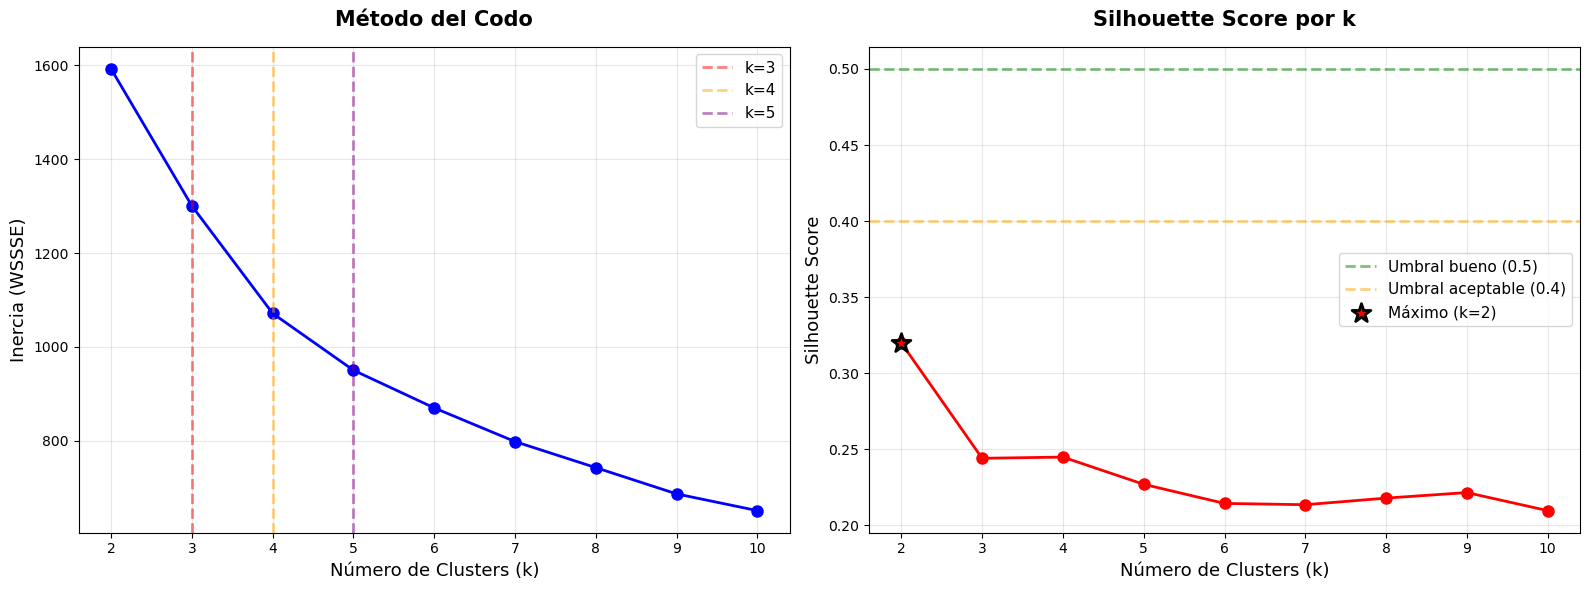


🎯 RECOMMEND OPTIUMUS K

📊 Silhouette Score max:
   k = 2 (score: 0.320)

📉 Según Método del Codo (segunda derivada):
   k ≈ 5

📋 COMPARATIVE (k=3, 4, 5)
 k     Inertia  Silhouette Best_Inertia Best_Silhouette
 3 1300.452242    0.244143            -               -
 4 1071.394211    0.244930       229.06           0.001
 5  950.291812    0.227036       121.10          -0.018


In [21]:
X_clustering = df_pca[['PC1', 'PC2', 'PC3', 'PC4']].values

print(f"📊 Data for clustering: {X_clustering.shape}")

k_values = range(2, 11)
inertias = []
silhouette_scores = []

print("\n=== EVALUATE THE NUMBER OF CLUSTERS ===\n")

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(X_clustering)
    
    # Calculate inertia (WSSSE)
    inertia = kmeans.inertia_
    inertias.append(inertia)
    
    # Calculate Silhouette Score
    silhouette = silhouette_score(X_clustering, cluster_labels)
    silhouette_scores.append(silhouette)
    
    print(f"k={k} → Inercia: {inertia:.2f}, Silhouette: {silhouette:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Elbow method
ax1 = axes[0]
ax1.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)', fontsize=13)
ax1.set_ylabel('Inercia (WSSSE)', fontsize=13)
ax1.set_title('Método del Codo', fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values)

# Possible elbows
ax1.axvline(x=3, color='red', linestyle='--', alpha=0.5, linewidth=2, label='k=3')
ax1.axvline(x=4, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='k=4')
ax1.axvline(x=5, color='purple', linestyle='--', alpha=0.5, linewidth=2, label='k=5')
ax1.legend(fontsize=11)

# Chart 2: Silhouette Score
ax2 = axes[1]
ax2.plot(k_values, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)', fontsize=13)
ax2.set_ylabel('Silhouette Score', fontsize=13)
ax2.set_title('Silhouette Score por k', fontsize=15, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_values)
ax2.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Umbral bueno (0.5)')
ax2.axhline(y=0.4, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Umbral aceptable (0.4)')
ax2.legend(fontsize=11)

# Marcar el máximo silhouette
max_silhouette_idx = np.argmax(silhouette_scores)
max_k = k_values[max_silhouette_idx]
ax2.scatter(max_k, silhouette_scores[max_silhouette_idx], 
            s=200, c='red', marker='*', edgecolors='black', linewidths=2,
            label=f'Máximo (k={max_k})', zorder=5)
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("🎯 RECOMMEND OPTIUMUS K")
print("="*80)

# Method 1: Max Silhouette
max_silhouette_k = k_values[np.argmax(silhouette_scores)]
print(f"\n📊 Silhouette Score max:")
print(f"   k = {max_silhouette_k} (score: {silhouette_scores[max_silhouette_k-2]:.3f})")

# Method 2: Elbow method (calculate second derivative)
differences = np.diff(inertias)
second_diff = np.diff(differences)
elbow_k = k_values[np.argmax(second_diff) + 2]  # +2 por los dos diff
print(f"\n📉 Según Método del Codo (segunda derivada):")
print(f"   k ≈ {elbow_k}")

# Method 3: Silhouette > 0.4 y k lower
acceptable_k = [k for k, s in zip(k_values, silhouette_scores) if s > 0.4]
if acceptable_k:
    print(f"\n✅ Valores de k con Silhouette > 0.4:")
    for k in acceptable_k:
        print(f"   k = {k}: {silhouette_scores[k-2]:.3f}")

# Comparative for k=3, 4, 5
print("\n" + "="*80)
print("📋 COMPARATIVE (k=3, 4, 5)")
print("="*80)

comparison_table = []
for k in [3, 4, 5]:
    idx = k - 2
    comparison_table.append({
        'k': k,
        'Inertia': inertias[idx],
        'Silhouette': silhouette_scores[idx],
        'Best_Inertia': '-' if k == 3 else f"{(inertias[idx-1] - inertias[idx]):.2f}",
        'Best_Silhouette': '-' if k == 3 else f"{(silhouette_scores[idx] - silhouette_scores[idx-1]):.3f}"
    })

comparison_df = pd.DataFrame(comparison_table)
print(comparison_df.to_string(index=False))

In [22]:
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=20, max_iter=300)
clusters_4 = kmeans_4.fit_predict(X_clustering)

kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=20, max_iter=300)
clusters_5 = kmeans_5.fit_predict(X_clustering)

df_pca['cluster_k4'] = clusters_4
df_pca['cluster_k5'] = clusters_5

print(f"\n✅ Clustering for k=4 and k=5")

print("\n=== CLUSTERS DISTRIBUTION ===")
print("\nk=4:")
print(df_pca['cluster_k4'].value_counts().sort_index())
print("\nk=5:")
print(df_pca['cluster_k5'].value_counts().sort_index())

print("\n=== CLUSTERS (k=4) ===")
cluster_profiles_4 = df_pca.groupby('cluster_k4')[['PC1', 'PC2', 'PC3', 'PC4']].mean()
print(cluster_profiles_4.round(2))

print("\n=== CLUSTERS (k=5) ===")
cluster_profiles_5 = df_pca.groupby('cluster_k5')[['PC1', 'PC2', 'PC3', 'PC4']].mean()
print(cluster_profiles_5.round(2))


✅ Clustering for k=4 and k=5

=== CLUSTERS DISTRIBUTION ===

k=4:
cluster_k4
0    93
1    31
2    96
3    60
Name: count, dtype: int64

k=5:
cluster_k5
0    70
1    54
2    74
3    52
4    30
Name: count, dtype: int64

=== CLUSTERS (k=4) ===
             PC1   PC2   PC3   PC4
cluster_k4                        
0          -1.71  0.87 -0.28 -0.19
1           4.72  0.17 -0.19 -0.20
2           0.99  0.13  0.26  0.02
3          -1.38 -1.66  0.12  0.37

=== CLUSTERS (k=5) ===
             PC1   PC2   PC3   PC4
cluster_k5                        
0           1.26 -0.24 -0.07 -0.08
1          -1.31 -1.76  0.21  0.42
2          -1.90  0.56 -0.72 -0.36
3          -0.39  1.23  1.00  0.29
4           4.78  0.20 -0.17 -0.19


In [23]:
df_pca['cluster'] = df_pca['cluster_k4']

cluster_order = df_pca.groupby('cluster')['PC1'].mean().sort_values(ascending=False)
print("\n=== CLUSTERS ORDENADOS POR PC1 (CALIDAD OFENSIVA) ===")
print(cluster_order)

cluster_mapping = {}
sorted_clusters = cluster_order.index.tolist()

cluster_mapping[sorted_clusters[0]] = "Dominadores Élite"
cluster_mapping[sorted_clusters[1]] = "Equilibrados Sólidos"
cluster_mapping[sorted_clusters[2]] = "Defensivos En Riesgo" 
cluster_mapping[sorted_clusters[3]] = "Intensidad Alta"

df_pca['cluster_label'] = df_pca['cluster'].map(cluster_mapping)

print("\n=== LABELS ASSIGNED ===")
for cluster_id, label in cluster_mapping.items():
    count = len(df_pca[df_pca['cluster'] == cluster_id])
    print(f"Cluster {cluster_id}: {label} ({count} teams)")

print("\n=== CLUSTER EXAMPLES ===")
for cluster_id in sorted_clusters:
    label = cluster_mapping[cluster_id]
    print(f"\n{label}:")
    examples = df_pca[df_pca['cluster'] == cluster_id][['team', 'year', 'location']].head(5)
    print(examples.to_string(index=False))


=== CLUSTERS ORDENADOS POR PC1 (CALIDAD OFENSIVA) ===
cluster
1    4.722283
2    0.989750
3   -1.376846
0   -1.707484
Name: PC1, dtype: float64

=== LABELS ASSIGNED ===
Cluster 1: Dominadores Élite (31 teams)
Cluster 2: Equilibrados Sólidos (96 teams)
Cluster 3: Defensivos En Riesgo (60 teams)
Cluster 0: Intensidad Alta (93 teams)

=== CLUSTER EXAMPLES ===

Dominadores Élite:
           team  year location
     villarreal 21/22     home
    real-madrid 22/23     home
atletico-madrid 25/26     home
    real-madrid 19/20     home
      barcelona 21/22     away

Equilibrados Sólidos:
           team  year location
        almeria 23/24     home
       valencia 24/25     home
  real-sociedad 25/26     home
real-valladolid 22/23     home
     celta-vigo 19/20     home

Defensivos En Riesgo:
    team  year location
valencia 20/21     away
 granada 20/21     away
  huesca 20/21     away
   cadiz 21/22     home
   elche 20/21     away

Intensidad Alta:
          team  year location
       gra

In [24]:
print("\n" + "="*80)
print("ANALYSIS DETAILED FOR CLUSTERS")
print("="*80)

for cluster_id in sorted_clusters:
    label = cluster_mapping[cluster_id]
    df_cluster = df_pca[df_pca['cluster'] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"{label} (n={len(df_cluster)})")
    print('='*80)
    
    print("\n📊 Main components (mean):")
    pc_means = df_cluster[['PC1', 'PC2', 'PC3', 'PC4']].mean()
    print(f"  PC1 (Calidad Ofensiva):    {pc_means['PC1']:+.2f}")
    print(f"  PC2 (Solidez Defensiva):   {pc_means['PC2']:+.2f}")
    print(f"  PC3 (Intensidad):          {pc_means['PC3']:+.2f}")
    print(f"  PC4 (Presión Alta):        {pc_means['PC4']:+.2f}")
    
    # Distribución home/away
    print("\n🏟️ Distribution Home/Away:")
    location_dist = df_cluster['location'].value_counts()
    for loc, count in location_dist.items():
        pct = count / len(df_cluster) * 100
        print(f"  {loc}: {count} ({pct:.1f}%)")
    
    print("\n🔝 Top 10 most frequent teams:")
    top_teams = df_cluster['team'].value_counts().head(10)
    for team, count in top_teams.items():
        print(f"  {team}: {count} times")

print("\n" + "="*80)
print("🏟️ ANALYSIS HOME vs AWAY per CLUSTER")
print("="*80)

for cluster_id in sorted_clusters:
    label = cluster_mapping[cluster_id]
    df_cluster = df_pca[df_pca['cluster'] == cluster_id]
    
    home_pct = (df_cluster['location'] == 'home').sum() / len(df_cluster) * 100
    away_pct = (df_cluster['location'] == 'away').sum() / len(df_cluster) * 100
    
    print(f"\n{label}:")
    print(f"  Home: {home_pct:.1f}% | Away: {away_pct:.1f}%")
    
    if home_pct > 70:
        print(f"  → Home team predominance")
    elif away_pct > 70:
        print(f"  → Away team predominance")
    else:
        print(f"  → Mix balanced")


ANALYSIS DETAILED FOR CLUSTERS

Dominadores Élite (n=31)

📊 Main components (mean):
  PC1 (Calidad Ofensiva):    +4.72
  PC2 (Solidez Defensiva):   +0.17
  PC3 (Intensidad):          -0.19
  PC4 (Presión Alta):        -0.20

🏟️ Distribution Home/Away:
  home: 20 (64.5%)
  away: 11 (35.5%)

🔝 Top 10 most frequent teams:
  barcelona: 14 times
  real-madrid: 10 times
  atletico-madrid: 3 times
  villarreal: 2 times
  athletic-club: 1 times
  girona-fc: 1 times

Equilibrados Sólidos (n=96)

📊 Main components (mean):
  PC1 (Calidad Ofensiva):    +0.99
  PC2 (Solidez Defensiva):   +0.13
  PC3 (Intensidad):          +0.26
  PC4 (Presión Alta):        +0.02

🏟️ Distribution Home/Away:
  home: 67 (69.8%)
  away: 29 (30.2%)

🔝 Top 10 most frequent teams:
  real-sociedad: 12 times
  atletico-madrid: 10 times
  sevilla: 10 times
  real-betis: 10 times
  villarreal: 9 times
  celta-vigo: 9 times
  athletic-club: 5 times
  valencia: 5 times
  rayo-vallecano: 5 times
  girona-fc: 4 times

Defensivos

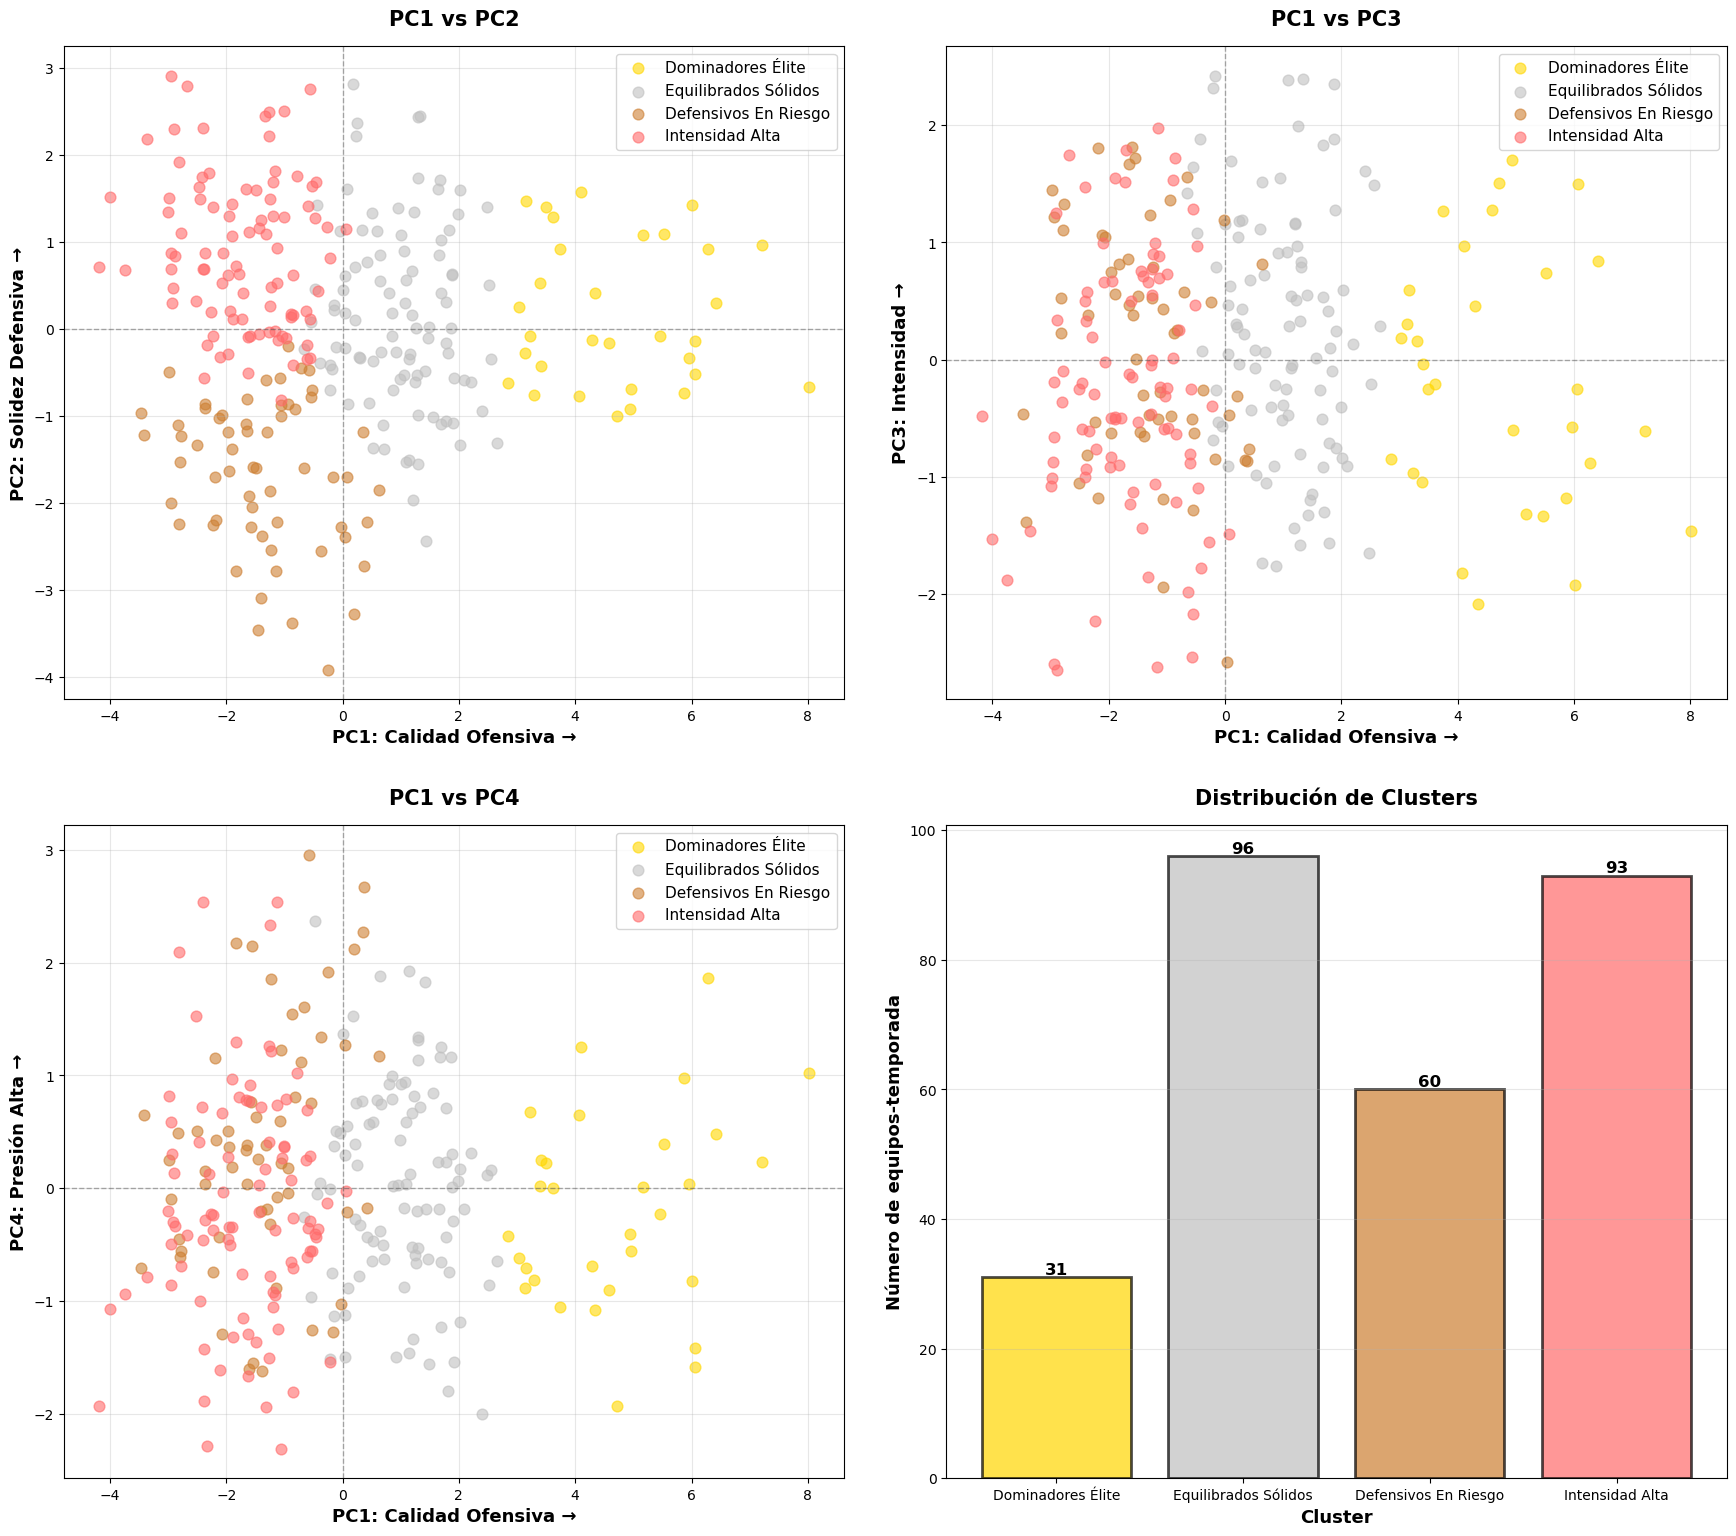

In [25]:
colors_map = {
    sorted_clusters[0]: '#FFD700',  # Oro - Dominadores Élite
    sorted_clusters[1]: '#C0C0C0',  # Plata - Equilibrados Sólidos
    sorted_clusters[2]: '#CD7F32',  # Bronce - Defensivos En Riesgo
    sorted_clusters[3]: '#FF6B6B'   # Rojo - Intensidad Alta
}

fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Chart 1: PC1 vs PC2
ax1 = axes[0, 0]
for cluster_id in sorted_clusters:
    df_cluster = df_pca[df_pca['cluster'] == cluster_id]
    label = cluster_mapping[cluster_id]
    ax1.scatter(df_cluster['PC1'], df_cluster['PC2'], 
                alpha=0.6, s=60, label=label, color=colors_map[cluster_id])

ax1.set_xlabel('PC1: Calidad Ofensiva →', fontsize=13, fontweight='bold')
ax1.set_ylabel('PC2: Solidez Defensiva →', fontsize=13, fontweight='bold')
ax1.set_title('PC1 vs PC2', fontsize=15, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.3, linewidth=1)

# Chart 2: PC1 vs PC3
ax2 = axes[0, 1]
for cluster_id in sorted_clusters:
    df_cluster = df_pca[df_pca['cluster'] == cluster_id]
    label = cluster_mapping[cluster_id]
    ax2.scatter(df_cluster['PC1'], df_cluster['PC3'],
                alpha=0.6, s=60, label=label, color=colors_map[cluster_id])

ax2.set_xlabel('PC1: Calidad Ofensiva →', fontsize=13, fontweight='bold')
ax2.set_ylabel('PC3: Intensidad →', fontsize=13, fontweight='bold')
ax2.set_title('PC1 vs PC3', fontsize=15, fontweight='bold', pad=15)
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.3, linewidth=1)

# Chart 3: PC1 vs PC4
ax3 = axes[1, 0]
for cluster_id in sorted_clusters:
    df_cluster = df_pca[df_pca['cluster'] == cluster_id]
    label = cluster_mapping[cluster_id]
    ax3.scatter(df_cluster['PC1'], df_cluster['PC4'],
                alpha=0.6, s=60, label=label, color=colors_map[cluster_id])

ax3.set_xlabel('PC1: Calidad Ofensiva →', fontsize=13, fontweight='bold')
ax3.set_ylabel('PC4: Presión Alta →', fontsize=13, fontweight='bold')
ax3.set_title('PC1 vs PC4', fontsize=15, fontweight='bold', pad=15)
ax3.legend(fontsize=11, loc='best')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
ax3.axvline(x=0, color='black', linestyle='--', alpha=0.3, linewidth=1)

# Chart 4: Distribución de clusters
ax4 = axes[1, 1]
cluster_counts = df_pca['cluster'].value_counts().reindex(sorted_clusters)
bars = ax4.bar(range(len(cluster_counts)), cluster_counts.values,
               color=[colors_map[c] for c in sorted_clusters], alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_xlabel('Cluster', fontsize=13, fontweight='bold')
ax4.set_ylabel('Número de equipos-temporada', fontsize=13, fontweight='bold')
ax4.set_title('Distribución de Clusters', fontsize=15, fontweight='bold', pad=15)
ax4.set_xticks(range(len(cluster_counts)))
ax4.set_xticklabels([cluster_mapping[c] for c in sorted_clusters], rotation=0)
ax4.grid(True, alpha=0.3, axis='y')

# Add var values
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout(pad=3.0)
plt.show()

In [26]:
color_map_pca = {
    sorted_clusters[0]: '#FFD700',  # Oro - Dominadores Élite
    sorted_clusters[1]: '#C0C0C0',  # Plata - Equilibrados Sólidos
    sorted_clusters[2]: '#CD7F32',  # Bronce - Defensivos En Riesgo
    sorted_clusters[3]: '#FF6B6B'   # Rojo - Intensidad Alta
}

fig_pca = make_subplots(
    rows=1, cols=2,
    subplot_titles=('HOME - Local', 'AWAY - Visitante'),
    horizontal_spacing=0.12
)

years = sorted(df_pca['year'].unique())

# Crear trazas por cluster, año y location
trace_index = 0
for year in years:
    for location in ['home', 'away']:
        for cluster_id in sorted_clusters:
            df_temp = df_pca[(df_pca['cluster'] == cluster_id) & 
                             (df_pca['year'] == year) &
                             (df_pca['location'] == location)].copy()
            
            label = cluster_mapping[cluster_id]
            color = color_map_pca[cluster_id]
            
            # Define col (1=home, 2=away)
            col = 1 if location == 'home' else 2
            
            # Show legend only for the 1st year
            show_legend = (location == 'home' and year == years[0])
            # show_legend = (location == 'home')
            
            fig_pca.add_trace(
                go.Scatter(
                    x=df_temp['PC1'],
                    y=df_temp['PC2'],
                    mode='markers',
                    name=label,
                    marker=dict(size=10, color=color, opacity=0.7, 
                               line=dict(width=1, color='white')),
                    text=df_temp['team'],
                    customdata=df_temp[['PC3', 'PC4']],
                    hovertemplate='<b>%{text}</b><br>' +
                                  'Temporada: ' + str(year) + '<br>' +
                                  'PC1 (Calidad): %{x:.2f}<br>' +
                                  'PC2 (Defensa): %{y:.2f}<br>' +
                                  'PC3 (Intensidad): %{customdata[0]:.2f}<br>' +
                                  'PC4 (Presión): %{customdata[1]:.2f}<br>' +
                                  '<extra></extra>',
                    # visible=(year == years[0]),
                    legendgroup=label,
                    showlegend=show_legend
                ),
                row=1, col=col
            )
            trace_index += 1

# Crear botones dropdown
buttons = []

# Botón "Todas las temporadas"
buttons.append(dict(
    label="ALL",
    method="update",
    args=[{"visible": [True] * len(fig_pca.data)},
          {"title": {"text": "<b>Clustering PCA: HOME vs AWAY - ALL Seasons</b>"}}]
))

# Botones por temporada
for year in years:
    visibility = []
    for y in years:
        for _ in ['home', 'away']:
            for _ in range(len(sorted_clusters)):
                visibility.append(y == year)
    
    buttons.append(
        dict(
            label=str(year),
            method="update",
            args=[{"visible": visibility},
                  {"title": {"text": f"<b>Clustering PCA: HOME vs AWAY - Season {year}</b>"}}]
        )
    )

# Update layout
fig_pca.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            direction="down",
            x=0.15,
            y=1.12,
            buttons=buttons,
            showactive=True,
            bgcolor='white',
            bordercolor='gray',
            font=dict(size=12)
        )
    ],
    title={
        'text': f"<b>Clustering PCA: HOME vs AWAY - ALL Seasons</b>",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    hovermode='closest',
    plot_bgcolor='white',
    height=600,
    width=1400,
    legend=dict(
        title="Cluster",
        font=dict(size=11),
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='gray',
        borderwidth=1,
        x=1.01,
        y=0.5
    ),
    showlegend=True
)

# Actualizar ejes
fig_pca.update_xaxes(
    title_text="PC1: Calidad Ofensiva →",
    gridcolor='lightgray',
    showgrid=True,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=2,
    row=1, col=1
)

fig_pca.update_xaxes(
    title_text="PC1: Calidad Ofensiva →",
    gridcolor='lightgray',
    showgrid=True,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=2,
    row=1, col=2
)

fig_pca.update_yaxes(
    title_text="PC2: Solidez Defensiva →",
    gridcolor='lightgray',
    showgrid=True,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=2,
    row=1, col=1
)

fig_pca.update_yaxes(
    title_text="PC2: Solidez Defensiva →",
    gridcolor='lightgray',
    showgrid=True,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=2,
    row=1, col=2
)

fig_pca.show()

print("\n✅ Interactive chart HOME vs AWAY")
print("📊 Use the dropdown for filter per season")
print("🏟️ Check the performance between home and away")


✅ Interactive chart HOME vs AWAY
📊 Use the dropdown for filter per season
🏟️ Check the performance between home and away


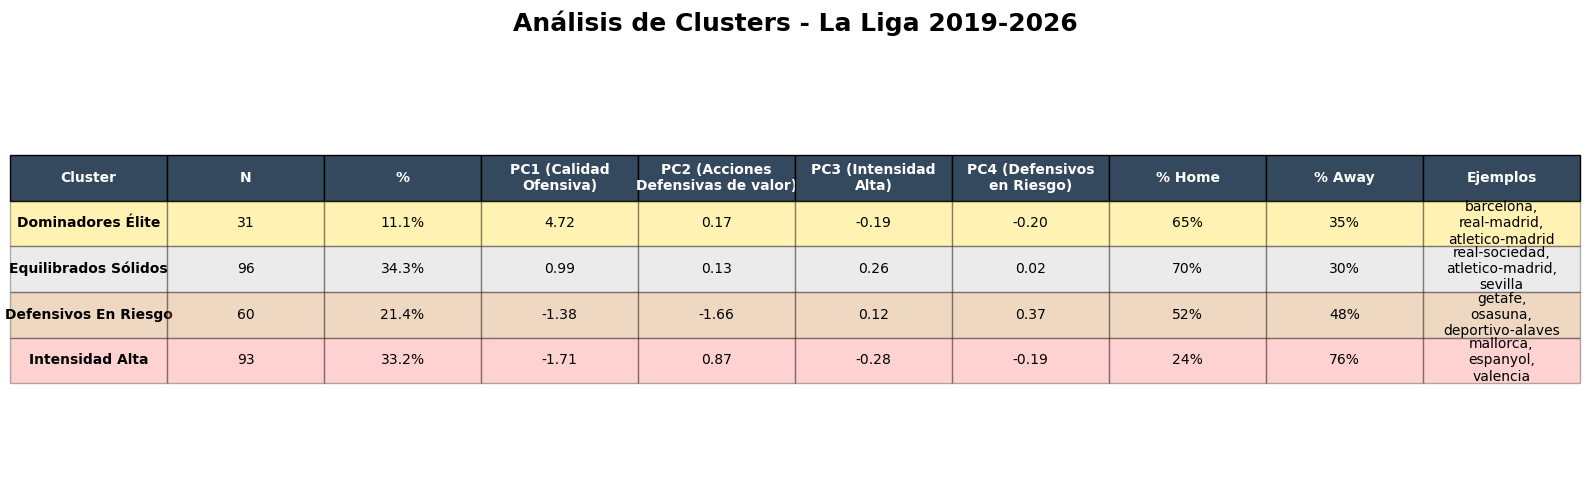

In [27]:
summary_data = []
row_colors = []

for cluster_id in sorted_clusters:
    df_cluster = df_pca[df_pca['cluster'] == cluster_id]
    summary_data.append({
        'Cluster': cluster_mapping[cluster_id],
        'N': len(df_cluster),
        '%': f"{len(df_cluster)/len(df_pca)*100:.1f}%",
        'PC1 (Calidad\nOfensiva)': f"{df_cluster['PC1'].mean():.2f}",
        'PC2 (Acciones\nDefensivas de valor)': f"{df_cluster['PC2'].mean():.2f}",
        'PC3 (Intensidad\nAlta)': f"{df_cluster['PC3'].mean():.2f}",
        'PC4 (Defensivos\nen Riesgo)': f"{df_cluster['PC4'].mean():.2f}",
        '% Home': f"{(df_cluster['location']=='home').sum()/len(df_cluster)*100:.0f}%",
        '% Away': f"{(df_cluster['location']=='away').sum()/len(df_cluster)*100:.0f}%",
        'Ejemplos': ',\n'.join(df_cluster['team'].value_counts().head(3).index)
    })
    
    row_colors.append(color_map_pca[cluster_id])

summary_df = pd.DataFrame(summary_data)

fig, ax = plt.subplots(figsize=(16, 5))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=summary_df.values,
                colLabels=summary_df.columns,
                cellLoc='center',
                loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

for i in range(len(summary_df.columns)):
    table[(0, i)].set_facecolor('#34495E')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(len(summary_data)):
    for j in range(len(summary_df.columns)):
        table[(i+1, j)].set_facecolor(row_colors[i])
        table[(i+1, j)].set_alpha(0.3)  # Transparencia para que sea legible
        
        if j == 0:
            table[(i+1, j)].set_text_props(weight='bold')

plt.title('Análisis de Clusters - La Liga 2019-2026', 
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
# plt.savefig('tabla_resumen_clusters.png', dpi=300, bbox_inches='tight',
#             facecolor='white')
plt.show()
# print("✅ Tabla guardada como 'tabla_resumen_clusters.png'")